In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from irt import IRTModel
from sklearn import svm
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from beta_irt.visualization.plots import newline
from beta_irt.visualization.plots import plot_parameters
from irt import beta_irt
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler
import edward as ed

In [2]:
!ls data/UCI\ -\ 45

 3Dsn.csv
 3D_spatial_network_description.txt
 3D_spatial_network.xlsx
 airfoil.csv
 airfoil_self_noise_description.txt
 bike_sharing_day.csv
 bike_sharing_day_description.txt
 bike_sharing_hour.csv
 bike_sharing_hour_description.txt
 blog_feedback.csv
 blog_feedback_description.txt
 carbon_nanotubes.csv
 carbon_nanotubes_description.txt
 cargo_freight_tracking.csv
 cargo_freight_tracking_description.txt
 challenger_space_shuttle_description.txt
 challengerss.csv
 communities_crimes_unnormalized.csv
 communities_crimes_unnormalized_description.txt
 concrete_compressive_strength.csv
 concrete_compressive_strength_description.txt
 concrete_slump_test.csv
 concrete_slump_test_description.txt
 container_crane_controller.csv
 container_crane_controller_description.txt
 conventional_social_media_movies.csv
 conventional_social_media_movies_description.txt
 cycle_power_plant.csv
 cycle_power_plant_description.txt
 daily_demand_forecasting_orders.csv
 daily_demand_forecasting_orders_descriptio

In [742]:
df = pd.read_csv('data/analcatdata_galapagos.csv', na_values=['?'])

In [743]:
df.head()

,Island,Observed.species,Native.species,Area(km^2),Elevation(m),Distance.nearest.island(km),Distance.Santa.Cruz(km),Area.adj.island(km^2)
0,Baltra,58,23.0,25.09,NaN,0.6,0.6,1.84
1,Bartolome,31,21.0,1.24,109.0,0.6,26.3,572.33
2,Caldwell,3,3.0,0.21,114.0,2.8,58.7,0.78
3,Champion,25,9.0,0.10,46.0,1.9,47.4,0.18
4,Caomano,2,1.0,0.05,NaN,1.9,1.9,903.82


In [744]:
print(len(df), len(df.dropna()), len(df.drop_duplicates()))

30 24 30


In [338]:
df = df.drop_duplicates()

In [441]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533 entries, 0 to 767
Data columns (total 9 columns):
buoy         533 non-null int64
day          533 non-null int64
latitude     533 non-null float64
longitude    533 non-null float64
zon_winds    533 non-null object
mer_winds    533 non-null object
humidity     533 non-null object
air_temp     533 non-null object
s_s_temp     533 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 41.6+ KB


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [735]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from irt import IRTModel
from sklearn import svm
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from beta_irt.visualization.plots import newline
from beta_irt.visualization.plots import plot_parameters
from irt import beta_irt
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler
import edward as ed
import os

#-------------------------------------Pre-processing-------------------------------------#

# Path
path_data = './data/'
path_uci = './data/UCI - 45/'

# Name of data set
name = 'analcatdata_michiganacc'

# Read csv
data = pd.read_csv(path_data + name + '.csv', na_values=['?'])
data = data.dropna()

# Parameters
rd = 42
noise_std = np.linspace(0, 0.8, 20)
max_std = noise_std.max()

# Variable selection
X = data.iloc[:, -2].values.reshape(-1,1)
y = data.iloc[:, -1]

# Split data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = rd)
indexes = list(y_train.index)

# Principal component analysis
pca = PCA(n_components= 1)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Standard scale
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)


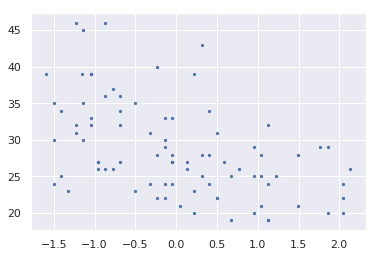

In [738]:
plt.scatter(X_train, y_train, s=5)

In [737]:
len(X_test)

22

In [7]:
path_data = './data/'
path_uci = './data/SELECTED/'

# Name of data set
name = 'mpg'

# Read csv
data = pd.read_csv(path_uci + name + '.csv')
data = data.dropna()

# Parameters
rd = 42
noise_std = np.linspace(0, 0.6, 20)
max_std = noise_std.max()

# Variable selection
X = data.iloc[:, 1:-3].values
y = data.iloc[:, 0].values

# Split data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = rd)
# indexes = list(y_train.index)

# Principal component analysis
pca = PCA(n_components= 1)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Standard scale
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# sc_y = StandardScaler()
# y_train = sc_y.fit_transform(y_train.reshape(-1,1)).reshape(1,-1)[0]
# y_test = sc_y.transform(y_test.reshape(-1,1)).reshape(1,-1)[0]

# Noise gen
noise_test = np.random.normal(loc=0.0, scale= 0.3, size= len(X_test))

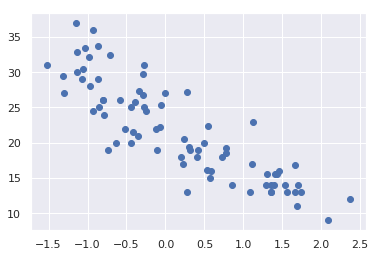

In [8]:
plt.scatter(X_test , y_test)